# Data Import and Configuration (Spotify)

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('datasets/spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

2023-09-27 11:57:06.756070: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-27 11:57:06.796970: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-27 11:57:06.797596: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 11:57:07.660642: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Input shape: [18]


## Add Dropout to Spotify Model

In [2]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dropout(rate=0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(rate=0.3),
    layers.Dense(1)
])

Minimum Validation Loss: 0.1917


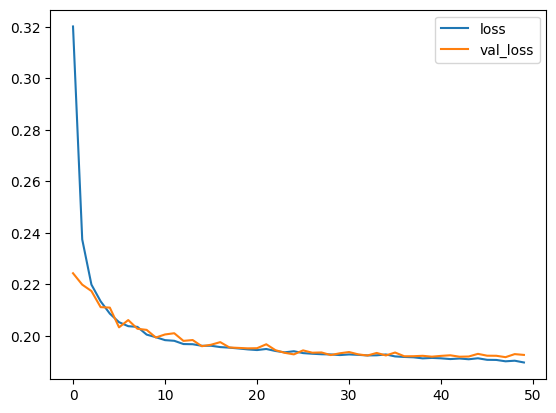

In [3]:
# Train the model

model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

# Data import and configuration

In [4]:
import pandas as pd

concrete = pd.read_csv('datasets/concrete.csv')
df = concrete.copy()

df_train = df.sample(frac=0.7, random_state=0)
df_valid = df.drop(df_train.index)

X_train = df_train.drop('CompressiveStrength', axis=1)
X_valid = df_valid.drop('CompressiveStrength', axis=1)
y_train = df_train['CompressiveStrength']
y_valid = df_valid['CompressiveStrength']

input_shape = [X_train.shape[1]]

Minimum Validation Loss: nan


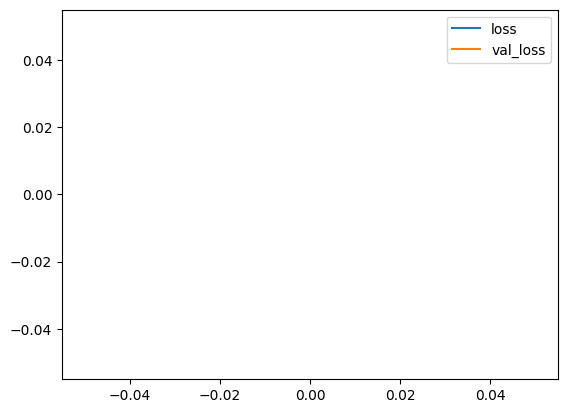

In [5]:
# Train the model on unstandardized data

model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.Dense(512, activation='relu'),    
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])
model.compile(
    optimizer='sgd', # SGD is more sensitive to differences of scale
    loss='mae',
    metrics=['mae'],
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=100,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

## Add Batch Normalization Layers

In [6]:
model = keras.Sequential([
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1),
])

Minimum Validation Loss: 4.0170


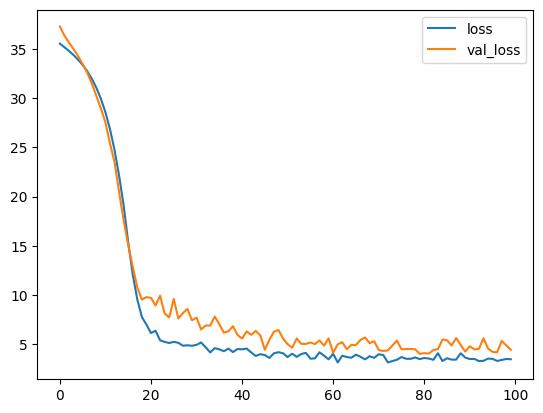

In [7]:
# Train the model

model.compile(
    optimizer='sgd',
    loss='mae',
    metrics=['mae'],
)
EPOCHS = 100
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=EPOCHS,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))